In [15]:
# 라이브러리 임포트

from google.cloud import bigquery
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


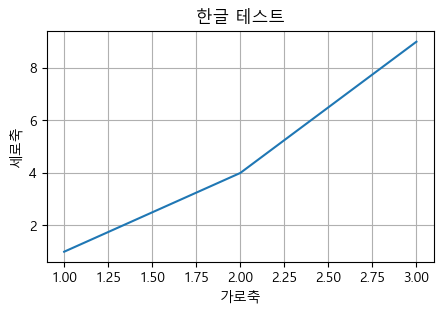

In [16]:
# 시각화 설정

import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 테스트
plt.figure(figsize=(5, 3))
plt.plot([1, 2, 3], [1, 4, 9])
plt.title("한글 테스트")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.grid(True)
plt.show()

In [17]:
# BigQuery 연결 설정

client = bigquery.Client()

PROJECT_ID = 'sesac-sd-bigquery-478605'  
DATASET = 'project'        

print(f"프로젝트: {PROJECT_ID}")
print(f"데이터셋: {DATASET}")

프로젝트: sesac-sd-bigquery-478605
데이터셋: project


In [18]:
# 테이블별 건수 확인

tables = ['users', 'products', 'sessions', 'events', 'orders', 'order_items']

counts = []
for table in tables:
    query = f"SELECT COUNT(*) as cnt FROM `{PROJECT_ID}.{DATASET}.{table}`"
    result = client.query(query).to_dataframe()
    counts.append({'table': table, 'count': result['cnt'][0]})

df_counts = pd.DataFrame(counts)
df_counts

,table,count
0,users,5000
1,products,600
2,sessions,505167
3,events,6575027
4,orders,410711
5,order_items,780214


In [19]:
# MBTI 분포 확인

query = f"""
SELECT 
    mbti,
    COUNT(*) AS user_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS percentage
FROM `{PROJECT_ID}.{DATASET}.users`
GROUP BY mbti
ORDER BY user_count DESC
"""

df_mbti = client.query(query).to_dataframe()
df_mbti

,mbti,user_count,percentage
0,ESFJ,437,8.74
1,ENFP,430,8.60
2,ISTJ,409,8.18
3,ESFP,406,8.12
4,ISFJ,401,8.02
5,ESTJ,382,7.64
6,ISFP,329,6.58
7,ENFJ,320,6.40
8,INFP,292,5.84
9,ESTP,264,5.28


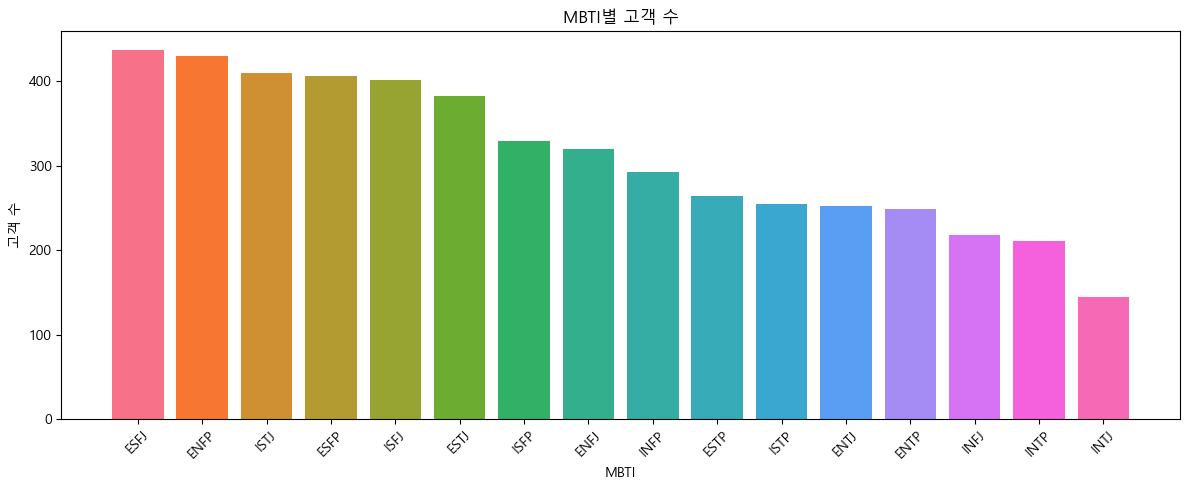

In [20]:
# MBTI 분포 시각화

plt.figure(figsize=(12, 5))
colors = sns.color_palette('husl', 16)
plt.bar(df_mbti['mbti'], df_mbti['user_count'], color=colors)
plt.title('MBTI별 고객 수')
plt.xlabel('MBTI')
plt.ylabel('고객 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# MBTI 축별 분포

query = f"""
SELECT 
    mbti_e_i,
    mbti_s_n,
    mbti_t_f,
    mbti_j_p,
    COUNT(*) as cnt
FROM `{PROJECT_ID}.{DATASET}.users`
GROUP BY mbti_e_i, mbti_s_n, mbti_t_f, mbti_j_p
"""

df_axis = client.query(query).to_dataframe()

# 축별로 집게리아
ei = df_axis.groupby('mbti_e_i')['cnt'].sum()
sn = df_axis.groupby('mbti_s_n')['cnt'].sum()
tf = df_axis.groupby('mbti_t_f')['cnt'].sum()
jp = df_axis.groupby('mbti_j_p')['cnt'].sum()

print("E/I 분포:")
print(ei)
print("\nS/N 분포:")
print(sn)
print("\nT/F 분포:")
print(tf)
print("\nJ/P 분포:")
print(jp)

E/I 분포:
mbti_e_i
E    2740
I    2260
Name: cnt, dtype: Int64

S/N 분포:
mbti_s_n
N    2117
S    2883
Name: cnt, dtype: Int64

T/F 분포:
mbti_t_f
F    2833
T    2167
Name: cnt, dtype: Int64

J/P 분포:
mbti_j_p
J    2564
P    2436
Name: cnt, dtype: Int64


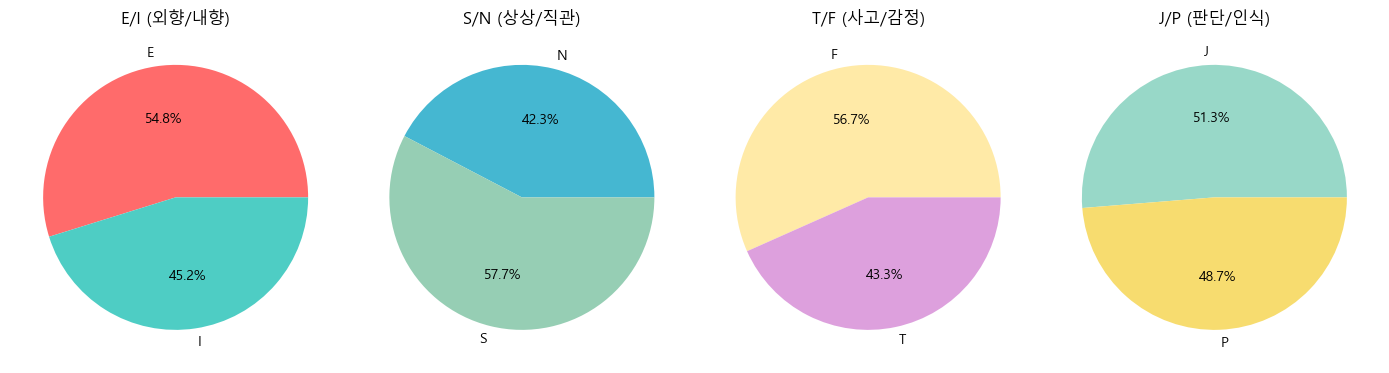

In [22]:
# MBTI 축별 분포 시각화

fig, axes = plt.subplots(1, 4, figsize=(14, 4))

axes[0].pie(ei.values, labels=ei.index, autopct='%1.1f%%', colors=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('E/I (외향/내향)')

axes[1].pie(sn.values, labels=sn.index, autopct='%1.1f%%', colors=['#45B7D1', '#96CEB4'])
axes[1].set_title('S/N (상상/직관)')

axes[2].pie(tf.values, labels=tf.index, autopct='%1.1f%%', colors=['#FFEAA7', '#DDA0DD'])
axes[2].set_title('T/F (사고/감정)')

axes[3].pie(jp.values, labels=jp.index, autopct='%1.1f%%', colors=['#98D8C8', '#F7DC6F'])
axes[3].set_title('J/P (판단/인식)')

plt.tight_layout()
plt.show()

In [23]:
# 고객 등급 분포

query = f"""
SELECT 
    customer_grade,
    COUNT(*) as user_count,
    ROUND(AVG(purchase_power), 2) as avg_purchase_power
FROM `{PROJECT_ID}.{DATASET}.users`
GROUP BY customer_grade
ORDER BY user_count DESC
"""

df_grade = client.query(query).to_dataframe()
df_grade

,customer_grade,user_count,avg_purchase_power
0,NORMAL,4233,1.00
1,GOLD,514,2.01
2,VIP,253,3.69


In [24]:
# 이벤트(Action) 분포

query = f"""
SELECT 
    event_type,
    action,
    COUNT(*) as event_count
FROM `{PROJECT_ID}.{DATASET}.events`
GROUP BY event_type, action
ORDER BY event_count DESC
"""

df_events = client.query(query).to_dataframe()
df_events

,event_type,action,event_count
0,funnel,view_item,3694673
1,funnel,add_to_cart,1333633
2,funnel,begin_checkout,552241
3,funnel,purchase,410711
4,funnel,cart_abandon,227101
5,funnel,checkout_abandon,141530
6,session,view_item,102449
7,post_purchase,write_review,75866
8,post_purchase,return,36080
9,lifecycle,churn,743


In [25]:
# 월별 주문 추이

query = f"""
SELECT 
    FORMAT_TIMESTAMP('%Y-%m', TIMESTAMP(order_date)) as month,
    COUNT(*) as order_count,
    SUM(total_amount) as total_revenue
FROM `{PROJECT_ID}.{DATASET}.orders`
GROUP BY month
ORDER BY month
"""

df_monthly = client.query(query).to_dataframe()
df_monthly

,month,order_count,total_revenue
0,2025-01,84446,11393667750
1,2025-02,62184,10152297600
2,2025-03,72025,11613493950
3,2025-04,57885,9589382550
4,2025-05,66284,10233968900
5,2025-06,67887,9990213800


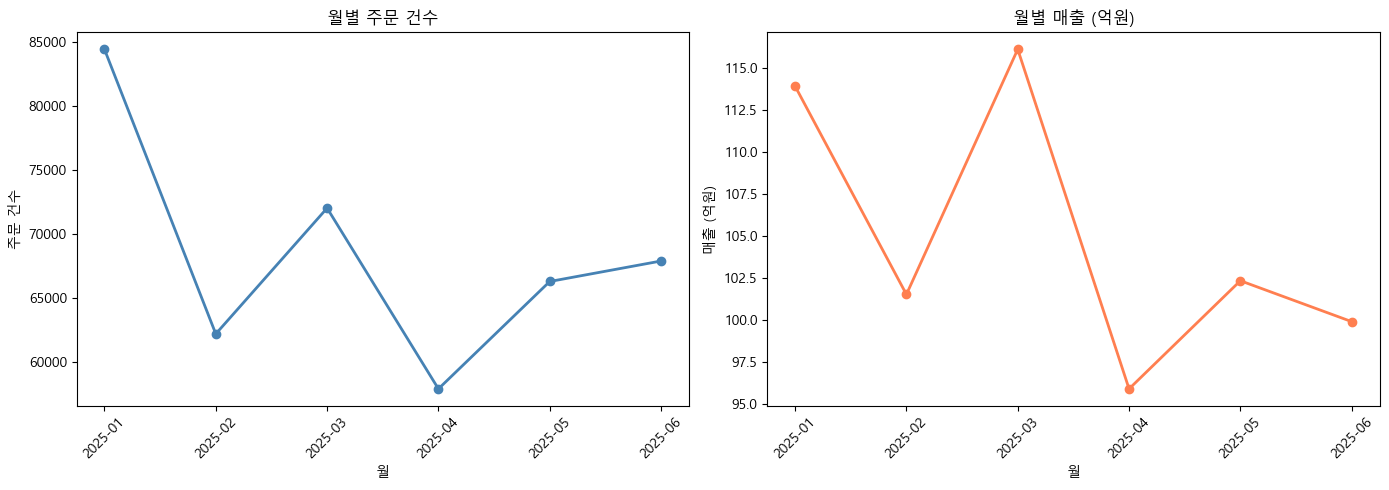

In [26]:
# 월별 추이 시각화

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(df_monthly['month'], df_monthly['order_count'], marker='o', linewidth=2, color='steelblue')
axes[0].set_title('월별 주문 건수')
axes[0].set_xlabel('월')
axes[0].set_ylabel('주문 건수')
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(df_monthly['month'], df_monthly['total_revenue'] / 1e8, marker='o', linewidth=2, color='coral')
axes[1].set_title('월별 매출 (억원)')
axes[1].set_xlabel('월')
axes[1].set_ylabel('매출 (억원)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [27]:
# 이탈 고객 현황

query = f"""
SELECT 
    is_churned,
    COUNT(*) as user_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
FROM `{PROJECT_ID}.{DATASET}.users`
GROUP BY is_churned
"""

df_churn = client.query(query).to_dataframe()
df_churn

,is_churned,user_count,percentage
0,False,4257,85.14
1,True,743,14.86


In [28]:
# 봇 트래픽 현황

query = f"""
SELECT 
    is_bot,
    COUNT(*) as event_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
FROM `{PROJECT_ID}.{DATASET}.events`
GROUP BY is_bot
"""

df_bot = client.query(query).to_dataframe()
df_bot

,is_bot,event_count,percentage
0,False,6472578,98.44
1,True,102449,1.56
